In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from replay_trajectory_classification import ClusterlessClassifier

from src.figure_utilities import set_figure_defaults
from src.parameters import TRANSITION_TO_CATEGORY

set_figure_defaults()

## Population Analysis

In [3]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info_95.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )
replay_info = replay_info.rename(index={"Cor": "cor"}).rename_axis(
    index={"animal": "Animal ID"}
)
replay_info.head()

Continuous  Continuous_duration  \
Animal ID day epoch ripple_number                                    
cor       1   2     1                   False                0.000   
                    2                   False                0.000   
                    3                   False                0.000   
                    4                    True                0.054   
                    5                   False                0.000   

                                   Continuous_max_probability  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                0.433000   
                    2                                0.145381   
                    3                                0.253176   
                    4                                0.984090   
                    5                                0.471484   

                                   Continuous_max_time  Continuous_min_time  \
Animal ID day epoch ripple_number                                             
cor       1   2     1                              NaN                  NaN   
                    2                              NaN                  NaN   
                    3                              NaN                  NaN   
                    4                            0.064                0.012   
                    5                              NaN                  NaN   

                                   Continuous_n_total_spikes  \
Animal ID day epoch ripple_number                              
cor       1   2     1                                    NaN   
                    2                                    NaN   
                    3                                    NaN   
                    4                                   78.0   
                    5                                    NaN   

                                   Continuous_n_unique_spiking  \
Animal ID day epoch ripple_number                                
cor       1   2     1                                      NaN   
                    2                                      NaN   
                    3                                      NaN   
                    4                                      9.0   
                    5                                      NaN   

                                   Continuous_population_rate  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                     NaN   
                    2                                     NaN   
                    3                                     NaN   
                    4                              131.313131   
                    5                                     NaN   

                                   Continuous_replay_distance_from_actual_position  \
Animal ID day epoch ripple_number                                                    
cor       1   2     1                                                          NaN   
                    2                                                          NaN   
                    3                                                          NaN   
                    4                                                     23.66645   
                    5                                                          NaN   

                                   Continuous_replay_distance_from_center_well  \
Animal ID day epoch ripple_number                                                
cor       1   2     1                                                      NaN   
                    2                                                      NaN   
                    3                                                      NaN   
                    4                                                 23.66645   
                    5                                                  

Text(0.5, 1, 'Ripples with\nclassified content')

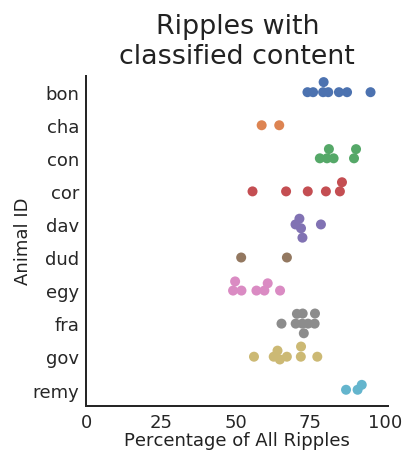

In [4]:
df = (
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of All Ripples",
    y="Animal ID",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
    size=3,
)
plt.xlim((0, 101))
plt.title("Ripples with\nclassified content")

In [5]:
num = (replay_info.is_classified).sum()
denom = len(replay_info)

print(f"Number classified: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number classified: 19180 / 25845 or 74%



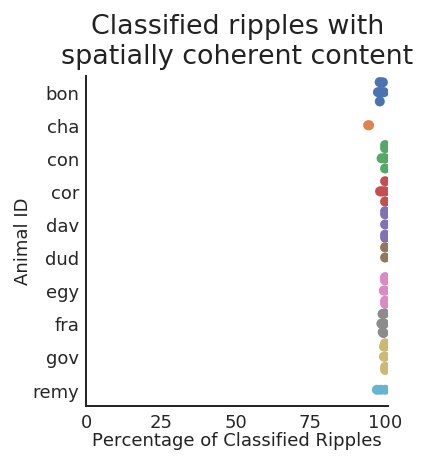

In [6]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(
        lambda df: (df["Hover"] | df["Hover-Continuous-Mix"] | df["Continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)
for kind in ["swarm"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="Animal ID",
        ci="sd",
        kind=kind,
        height=PAGE_HEIGHT / 4,
        size=3,
    )
    plt.xlim((0, 101))
    plt.title("Classified ripples with\nspatially coherent content")

In [7]:
classified_replay_info = replay_info.loc[replay_info.is_classified]
spatially_coherent = (
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)
num = spatially_coherent.sum()
denom = len(classified_replay_info)

print(f"Number spatially coherent: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number spatially coherent: 19020 / 19180 or 99%



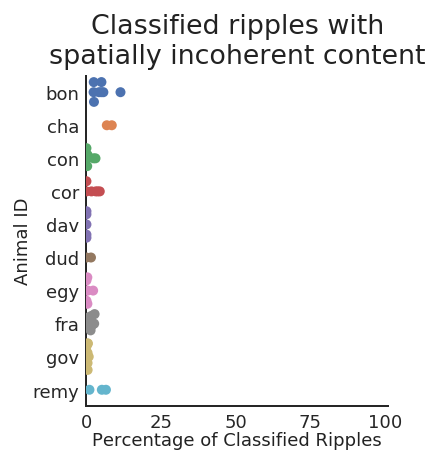

In [8]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Fragmented-Continuous-Mix"] | df["Fragmented"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)
for kind in ["swarm"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="Animal ID",
        ci="sd",
        kind=kind,
        height=PAGE_HEIGHT / 4,
        size=3,
    )
    plt.xlim((0, 101))
    plt.title("Classified ripples with\nspatially incoherent content")

In [9]:
spatially_incoherent = (
    classified_replay_info["Fragmented-Continuous-Mix"]
    | classified_replay_info["Fragmented"]
)
num = spatially_incoherent.sum()
denom = len(classified_replay_info)

print(f"Number spatially incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number spatially incoherent: 484 / 19180 or 3%



Text(0.5, 1, 'Classified ripples with\ncontinuous content')

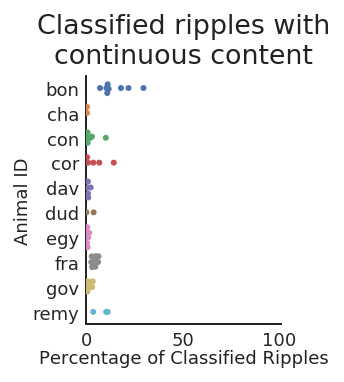

In [10]:
df = (
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Continuous"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of Classified Ripples",
    y="Animal ID",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
    s=3,
)
plt.xlim((0, 101))
plt.title("Classified ripples with\ncontinuous content")

In [11]:
num = classified_replay_info["Continuous"].sum()
denom = len(classified_replay_info)

print(f"Number continuous: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number continuous: 1475 / 19180 or 8%



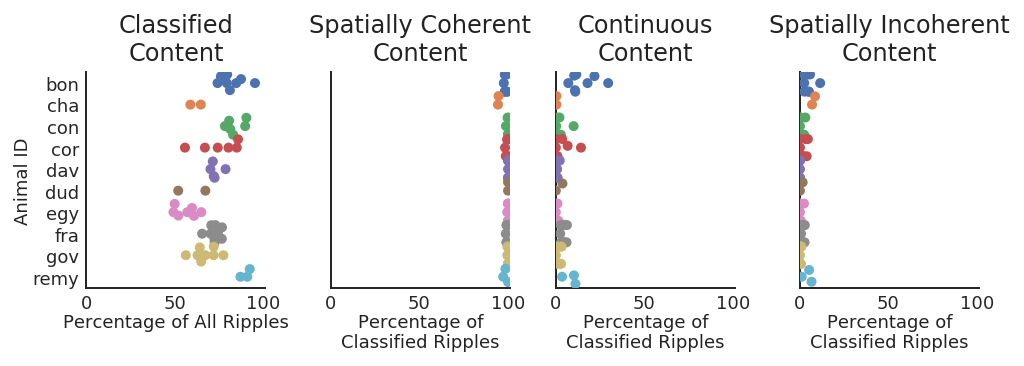

In [12]:
fig, axes = plt.subplots(
    1,
    4,
    figsize=(TWO_COLUMN, PAGE_HEIGHT / 4),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

# ax 0
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All Ripples")
).reset_index()

sns.swarmplot(
    data=df, x="Percentage of All Ripples", y="Animal ID", ax=axes[0],
)
axes[0].set_title("Classified\nContent", fontsize=12)

# ax 1
df = pd.DataFrame(
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(
        lambda df: (df["Hover"] | df["Hover-Continuous-Mix"] | df["Continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
).reset_index()
sns.swarmplot(
    data=df, x="Percentage of Classified Ripples", y="Animal ID", ax=axes[1],
)
axes[1].set_ylabel("")
axes[1].set_xlabel("Percentage of\nClassified Ripples")
axes[1].set_title("Spatially Coherent\nContent", fontsize=12)

# ax 2
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Continuous"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
).reset_index()

sns.swarmplot(
    data=df, x="Percentage of Classified Ripples", y="Animal ID", ax=axes[2],
)
axes[2].set_xlabel("Percentage of\nClassified Ripples")
axes[2].set_ylabel("")
axes[2].set_title("Continuous\nContent", fontsize=12)

# ax 3
df = pd.DataFrame(
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Fragmented-Continuous-Mix"] | df["Fragmented"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
).reset_index()
sns.swarmplot(
    data=df, x="Percentage of Classified Ripples", y="Animal ID", ax=axes[3],
)
axes[3].set_ylabel("")
axes[3].set_xlabel("Percentage of\nClassified Ripples")
axes[3].set_title("Spatially Incoherent\nContent", fontsize=12)
plt.xlim((0, 101))

sns.despine()